# Fit BNN to Predict [High Risk] v. [Low or Medium Risk]

COMPAS recidivism risk score data and previous analysis available through [ProPublica](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis).

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.stats import spearmanr, rankdata
import pandas as pd
import random
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Import RATE package
# See https://github.com/lorinanthony/RATE/tree/master/Software/rate-bnn to install
from rate import *

## How-To

The toggles in the cell below are most important, although there are other tweaks you can make throughout the script.

(a) Set `multiclass = True` if you want the outcome to be raw risk class: Low, Medium, High. Leaving `multiclass = False` bins Medium and High into a single group, as Propublica did.

(b) Whether you choose to model a binary or multiclass outcome, run all cells in this notebook twice: once with `variables_to_remove = []` and next with `variables_to_remove = ['priors_count']`. Do not restart the kernel between runs. The result is a dataset `rate_data_csv` that may be written to file (uncomment last cell when ready to do so). The contents are first and second order RATE values when all variables are included, and first and second order RATE values when number of prior offenses is omitted.

Restart the kernel if you have generated `rate_data_csv` for either the binary or multiclass case and would like to repeat analysis for the remaining case.

COMPAS_BNN_RATE.csv and COMPAS_BNN_RATE_multinomialResponse.csv are the files saved if the above instructions are followed in the binary and multiclass case, respectively. These are required to run plot.R, the script that constructs the paper plots.

In [2]:
# Options for analysis

# if True, use raw risk class: Low, Medium, High.
# if False, analyze as ProPublica did, binning Medium/High into a single group (this is our primary interest)
multiclass = False

# At first pass, it is not advised you remove variables
variables_to_remove = []
# variables_to_remove = ['priors_count']  # Uncomment at second pass, per instructions above

In [3]:
# Load COMPAS data
raw_data = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

# Remove missingness as ProPublica did
complete_data = raw_data[(raw_data['days_b_screening_arrest'] <= 30) & 
         (raw_data['days_b_screening_arrest'] >= -30) & 
         (raw_data['is_recid'] != -1) & 
         (raw_data['c_charge_degree'] != 'O') & 
         (raw_data['score_text'] != 'N/A')]

# Organize factors same as ProPublica
complete_data.rename(index=str, columns={"c_charge_degree": "crime_factor"}, inplace=True)

complete_data['race_factor'] = complete_data['race'].astype('category')
complete_data['race_factor'].cat.reorder_categories(['Caucasian', 'African-American', 
                                             'Asian', 'Hispanic', 
                                             'Native American', 'Other'], inplace=True)

complete_data['gender_factor'] = complete_data['sex'].astype('category')
complete_data['gender_factor'].cat.reorder_categories(['Male', 'Female'], inplace=True)

complete_data['age_factor'] = complete_data['age_cat']

C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [4]:
# Bin Medium and High together, as ProPublica did, or leave Low, Medium, High as three classes.

if multiclass: 
    # three responses
    complete_data['score_factor'] = complete_data['score_text'].astype('category')
    complete_data['score_factor'].cat.reorder_categories(['Low', 'Medium', 'High'], inplace=True)
    
    # One-hot encode features
    onehot_predictors = pd.get_dummies(complete_data, 
                             columns = ['crime_factor', 'age_factor', 
                                       'race_factor', 'gender_factor'], 
                            drop_first = True)
    
    # need three one-hot columns to persist for response
    onehot_response = pd.get_dummies(complete_data, columns = ['score_factor'])
    response_columns = ['score_factor_Low', 'score_factor_Medium', 'score_factor_High']
    
    onehot_data = pd.concat([onehot_predictors.reset_index(drop=True), 
                         onehot_response.ix[:, response_columns].reset_index(drop=True)], axis=1)
else: 
    # binary response: Low v. Medium/High
    complete_data['score_factor'] = np.where(complete_data['score_text'] == 'Low', 'LowScore', 'HighScore')
    complete_data['score_factor'] = complete_data['score_factor'].astype('category')
    complete_data['score_factor'].cat.reorder_categories(['LowScore', 'HighScore'], inplace=True)
    
    # One-hot encode features
    onehot_data = pd.get_dummies(complete_data, 
                             columns = ['crime_factor', 'age_factor', 
                                       'race_factor', 'gender_factor', 
                                       'score_factor'], 
                            drop_first = True)
    
    response_columns = ['score_factor_HighScore']

C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Use the features ProPublica used, less observed two year recidivism
ProPublica_features = ['crime_factor_M', 
                        'priors_count', 
                        'age_factor_Greater than 45', 
                        'age_factor_Less than 25', 
                        'race_factor_African-American', 
                        'race_factor_Asian', 
                        'race_factor_Hispanic', 
                        'race_factor_Native American', 
                        'race_factor_Other', 
                        'gender_factor_Female']

# Recall full feature list length (with one-hot) for plots
num_ProPublica_features = len(ProPublica_features)

# Add response vector
model_columns = ProPublica_features  # use ProPublica predictors
model_columns.extend(response_columns)  # add response column(s)

# Define PANDAS modeling data
model_data = onehot_data.ix[:, model_columns]

C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [6]:
# Remove variables, if user added any to variables_to_remove vector

if len(variables_to_remove) > 0:
    model_data.drop(variables_to_remove, axis=1, inplace=True)

In [7]:
# Define training and test splits
# This is not necessary, as we are not interested in prediction

train_test_splits = False

if train_test_splits: 
    x_train, x_test = train_test_split(model_data, test_size=0.2)
    y_train_mat = x_train.ix[:, response_columns].values
    x_train.drop(columns = response_columns, inplace=True)
    bnn_predictors = x_train.columns
    x_train_mat = x_train.values
    
    y_test_mat = x_test.ix[:, response_columns].values
    x_test.drop(columns = response_columns, inplace=True)
    x_test_mat = x_test.values
else: 
    x_train = model_data
    y_train_mat = x_train.ix[:, response_columns].values
    y_test_mat = y_train_mat
    x_train.drop(columns = response_columns, inplace=True)
    bnn_predictors = x_train.columns
    x_train_mat = x_train.values
    x_test_mat = x_train_mat
    
n_train = x_train_mat.shape[0]
n_test = x_test_mat.shape[0]

# Input and output dimensionality
p = x_train_mat.shape[1]
C = y_train_mat.shape[1]

# set up space to save rate values
if 'rate_data_csv' not in locals():
    rate_data_csv = pd.DataFrame({"var_names": ProPublica_features})

C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Now define the network architecture. The BNN class constructor (defined in BayesNN) takes a list of Tensorflow layers. 

If the layers cannot be combined to make a model the build_model method (called in the constructor) will throw an error. This is usually because of mismatching shapes.

The architecture of this network is

    flatten -> dense layers -> dense Bayesian layer (-> softmax if making prediction)

In [8]:
layers = []

# num. neurons for reasonable training
alpha = 2
layer_one_size = np.floor(n_train / (alpha * (p + C)))
layer_two_size = np.floor(layer_one_size + C * 2 / 3)

# add layers
layers.append(tf.keras.layers.Dense(layer_one_size, activation='relu', input_shape = (p,)))
layers.append(tf.keras.layers.Dense(layer_one_size, activation='relu'))
layers.append(tf.keras.layers.Dense(layer_two_size, activation='relu'))

layers.append(tfp.layers.DenseReparameterization(C))  # PREFER DenseLocalReparameterization, but having troubles.

W0715 14:04:52.550825  9736 deprecation.py:506] From C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Now create the BNN object:

In [9]:
bnn = BNN_Classifier(layers, p, C)

W0715 14:04:53.100710  9736 deprecation.py:323] From C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Now train the network by calling the `train` method, which returns the training loss at each epoch and leaves the network trained.

In [10]:
n_epochs = 100
batch_size = 25
bnn.train(x_train_mat, y_train_mat, n_epochs, batch_size)

Epoch 1/100
6172/6172 [==============================] - 1s 135us/sample - loss: 715.4353 - acc: 0.7202
Epoch 2/100
6172/6172 [==============================] - 1s 105us/sample - loss: 645.3450 - acc: 0.7285
Epoch 3/100
6172/6172 [==============================] - 1s 105us/sample - loss: 577.0815 - acc: 0.7263
Epoch 4/100
6172/6172 [==============================] - 1s 106us/sample - loss: 510.5973 - acc: 0.7234
Epoch 5/100
6172/6172 [==============================] - 1s 100us/sample - loss: 445.8768 - acc: 0.7187
Epoch 6/100
6172/6172 [==============================] - 1s 101us/sample - loss: 383.5995 - acc: 0.7238
Epoch 7/100
6172/6172 [==============================] - 1s 101us/sample - loss: 324.1237 - acc: 0.7223
Epoch 8/100
6172/6172 [==============================] - 1s 92us/sample - loss: 268.7270 - acc: 0.7092
Epoch 9/100
6172/6172 [==============================] - 1s 96us/sample - loss: 217.7350 - acc: 0.7122
Epoch 10/100
6172/6172 [==============================] - 1s 114us

In [11]:
# Evaluate
if train_test_splits:
    # Test settings - the number of posterior samples
    n_test_samples = 100

    print(bnn.score(x_test_mat, y_test_mat, n_test_samples))

## RATE

Now compute RATE. Start with the means and covariances of the final layer. Then get the network output at the penultimate layer, `H`, and use it to compute the means and covariances of the multivariate effect size analgoues.

In [12]:
M_W, V_W, b = bnn.var_params() # Means and covariances of the variational parameters (final layer weight matrix elements)
X = x_test_mat # Using the whole test set
H = bnn.compute_H(X) # (Deterministic) values of penultimate network layer
effect_size = 'covariance'  # use covariance analogue
M_B, V_B = compute_B(X, H, M_W, V_W, b, C, effect_size_analogue=effect_size) # Means and covariances of the effect size analogues
rate = [RATE(mu_c=M_B[c,:], Lambda_c=V_B[c,:,:]) for c in range(C)] # Per-class RATE values. First order centrality.

Computing RATE with 10 variables
Variable #: 0 done


In [13]:
# Assemble RATE dataset with covariate names
# RATE vectors should agree with one another.
# Be mindful that from here on, when organizing RATE values into dataset to save, 
# if a variable was removed, it is hardcoded in some places that that variable is priors_count.
# Modify as desired.

rate_data = pd.DataFrame(np.transpose([rate[c] for c in range(C)]), 
                         # rate_class0 is the label in the binary case because there's only 1 response vector.
                         columns=list(['rate_class' + str(c) for c in range(C)]))

column_dict = {#'two_year_recid': 'Reoffended (Y/N)', 
          'crime_factor_M': 'Severity of Charge: M', 
          'priors_count': 'Num. Priors', 
          'priors_count_shuffled': 'Num. Priors Shuffled',
          'priors_count_normalsmp': 'Num. Priors Standard Normal Sample', 
          'age_factor_Greater than 45': '> 45 Yrs. Old', 
          'age_factor_Less than 25': '< 25 Yrs. Old', 
          'race_factor_African-American': 'Race: African-American', 
          'race_factor_Asian': 'Race: Asian', 
          'race_factor_Hispanic': 'Race: Hispanic', 
          'race_factor_Native American': 'Race: Native-American', 
          'race_factor_Other': 'Race: Other', 
          'gender_factor_Female': 'Female'}  
rate_data['var_names'] = bnn_predictors
rate_data['feature'] = [column_dict[col] for col in rate_data['var_names']]

# if using all features, 
# want to remember this ordering 
# first order centrality, all variables included
# when you run this script, be sure to run that first!
# this doesn't matter in binary case, but note that for multiclass, this ordering 
#    goes by importance for predicting score=Low.
if num_ProPublica_features == len(bnn_predictors):
    rate_data.sort_values(by=['rate_class0'], inplace=True, ascending=False)

    # save sort order
    all_features_order = rate_data['feature']
    sorterIndex = dict(zip(all_features_order, range(len(all_features_order))))

rate_data['first_order_ranking'] = rate_data['feature'].map(sorterIndex)
rate_data.sort_values(by = ['first_order_ranking'], inplace=True)
centrality_label = 'First'

# save this data for when we write to csv
if num_ProPublica_features > len(bnn_predictors):
    # we are omitting priors_count from the analysis
    rate_data_temp = rate_data.copy()
    line_to_append = dict.fromkeys(rate_data_temp.columns)
    line_to_append['var_names'] = 'priors_count'
    line_to_append['feature'] = column_dict['priors_count']
    line_to_append['rate_class0'] = 0
    line_to_append['rate_class1'] = 0
    line_to_append['rate_class2'] = 0
    rate_data_temp = rate_data_temp.append(line_to_append, ignore_index=True)
    identifying_tag = "_numPriorsOmitted"
elif num_ProPublica_features == len(bnn_predictors):
    # including all predictors
    identifying_tag = ""

# modify rate_data_csv!
if not multiclass: 
    # binary case
    
    if num_ProPublica_features > len(bnn_predictors): 
        # if we're omitting num. priors
        rate_data_csv = rate_data_csv.merge(rate_data_temp.ix[:, ["var_names", "rate_class0"]], on=["var_names"])
    elif num_ProPublica_features == len(bnn_predictors):
        # all variables are included in the analysis
        rate_data_csv = rate_data_csv.merge(rate_data.ix[:, ["var_names", "rate_class0"]], on=["var_names"])
        
    rate_data_csv.rename(index=str, columns={"rate_class0": "rate_class0_1stOrder" + identifying_tag}, 
                        inplace=True)
else: 
    # three responses
    if num_ProPublica_features > len(bnn_predictors): 
        # if we're omitting num. priors
        rate_data_csv = rate_data_csv.merge(rate_data_temp.ix[:, ["var_names", "rate_class0", "rate_class1", "rate_class2"]], 
                                            on=["var_names"])
    elif num_ProPublica_features == len(bnn_predictors):
        # all variables are included in the analysis 
        rate_data_csv = rate_data_csv.merge(rate_data.ix[:, ["var_names", "rate_class0", "rate_class1", "rate_class2"]], 
                                            on=["var_names"])
    
    rate_data_csv.rename(index=str, columns={"rate_class0": "rate_class0_1stOrder" + identifying_tag, 
                                        "rate_class1": "rate_class1_1stOrder" + identifying_tag, 
                                        "rate_class2": "rate_class2_1stOrder" + identifying_tag}, inplace=True)

C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


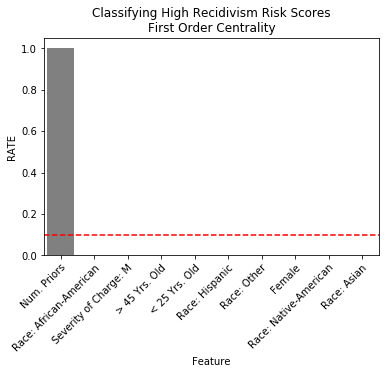

In [14]:
# Plot RATE values

if not multiclass: 
    # binary case
    fig = sns.barplot(x="feature", y="rate_class0", color = "gray", data=rate_data)
    fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha="right")
    for item in fig.get_xticklabels():
        item.set_rotation_mode('anchor')
    title_text = 'Classifying High Recidivism Risk Scores\n' + centrality_label + ' Order Centrality'
    fig.set(xlabel='Feature', ylabel='RATE', title=title_text)
    fig.axhline(y = 1.0 / len(x_train.columns), ls='--', color = "red")  # add line at 1/p (all variables equally important)
else: 
    # three responses
    print('Classifying High Recidivism Risk Scores\n' + centrality_label + ' Order Centrality')
            
    fig, axs = plt.subplots(1, 3)
    for response in np.arange(C):
        fig = sns.barplot(x="feature", y="rate_class" + str(response), color = "gray", data=rate_data, ax=axs[response])
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha="right")
        for item in fig.get_xticklabels():
            item.set_rotation_mode('anchor')
        fig.set(xlabel='Feature', ylabel='RATE', title=response_columns[response])
        fig.axhline(y = 1.0 / len(x_train.columns), ls='--', color = "red")  # add line at 1/p (all variables equally important)

In [15]:
# Second order centrality (condition on num. priors effect size = 0)

if effect_size == 'linear': 
    var_to_nullify = np.array(rate_data.ix[rate_data['first_order_ranking'] == 0, 'var_names'])[0]
    nullified_var_label = "_pseudoInv"
elif num_ProPublica_features == len(bnn_predictors): 
    # all variables are included in the analysis
    var_to_nullify = 'priors_count'
    nullified_var_label = ''
elif num_ProPublica_features > len(bnn_predictors): 
    # priors count is omitted from the analysis
    var_to_nullify = 'race_factor_African-American'
    nullified_var_label = '_numPriorsOmitted'

priors_count_idx = list(bnn_predictors).index(var_to_nullify)
rate = [RATE(mu_c=M_B[c,:], Lambda_c=V_B[c,:,:], nullify=[priors_count_idx]) for c in range(C)] # Per-class RATE values. 2nd order

rate_data = pd.DataFrame(np.transpose([rate[c] for c in range(C)]), 
                         columns=list(['rate_class' + str(c) for c in range(C)]))

var_names = list(bnn_predictors)
var_names.remove(var_to_nullify)
rate_data['var_names'] = var_names
if not multiclass: 
    # binary case
    rate_data.append({'rate_class0': 0, 'var_names': var_to_nullify}, ignore_index=True)
else: 
    # three responses
    rate_data.append({'rate_class0': 0, 'rate_class1': 0, 'rate_class2': 0, 'var_names': var_to_nullify}, ignore_index=True)
rate_data['feature'] = [column_dict[col] for col in rate_data['var_names']]

# include nullified variable on plot, for visual continuity, though it has no RATE value
missing_features = set(bnn_predictors) - set(var_names)
centrality_label = {2:'Second', 3:'Third', 4:'Fourth', 5:'Fifth', 6:'Sixth', 7:'Seventh', 8:'Eighth'}[len(missing_features)+1]
for var in missing_features:
    if not multiclass: 
        # binary case
        rate_data = rate_data.append({'var_names': var, 
                                     'rate_class0': 0}, ignore_index=True)
    else: 
        # three responses
        rate_data = rate_data.append({'var_names': var, 
                                     'rate_class0': 0, 
                                     'rate_class1': 0, 
                                     'rate_class2': 0}, ignore_index=True)
        
# order by first order centrality   
# you have to have previously run first order centrality!
rate_data['first_order_ranking'] = rate_data['feature'].map(sorterIndex)
rate_data.sort_values(by = ['first_order_ranking'], inplace=True)

# save this data for when we write to csv
rate_data_temp = rate_data.copy()
if var_to_nullify == 'race_factor_African-American':
    # if priors count is omitted fully from the analysis
    line_to_append = dict.fromkeys(rate_data_temp.columns)
    line_to_append['var_names'] = 'priors_count'
    line_to_append['feature'] = column_dict['priors_count']
    line_to_append['rate_class0'] = 0
    if multiclass: 
        line_to_append['rate_class1'] = 0
        line_to_append['rate_class2'] = 0
    rate_data_temp = rate_data_temp.append(line_to_append, ignore_index=True)

if not multiclass: 
    # binary case
    rate_data_csv = rate_data_csv.merge(rate_data_temp.ix[:, ['var_names', 'rate_class0']], on = ['var_names'])
    rate_data_csv.rename(index=str, columns={"rate_class0": "rate_class0_2ndOrder" + nullified_var_label}, 
                        inplace=True)
else: 
    # three responses
    rate_data_csv = rate_data_csv.merge(rate_data_temp.ix[:, ['var_names', 'rate_class0', 'rate_class1', 'rate_class2']], 
                                        on = ['var_names'])
    rate_data_csv.rename(index=str, columns={"rate_class0": "rate_class0_2ndOrder" + nullified_var_label, 
                                            "rate_class1": "rate_class1_2ndOrder" + nullified_var_label, 
                                            "rate_class2": "rate_class2_2ndOrder" + nullified_var_label}, 
                        inplace=True)

Computing RATE with 9 variables
Variable #: 0 done


C:\Users\Dana Udwin\Anaconda3\envs\neurips\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


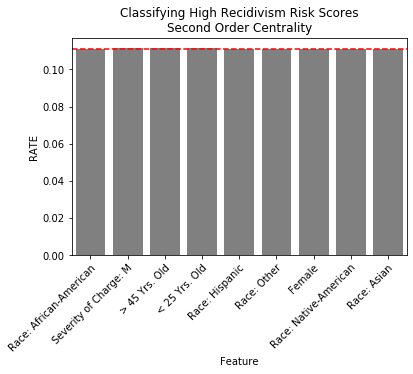

In [16]:
# Plot 2nd Order RATE values

if not multiclass: 
    # binary case
    fig = sns.barplot(x="feature", y="rate_class0", color = "gray", data=rate_data)
    fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha="right")
    for item in fig.get_xticklabels():
    #     item.set_rotation(45)
        item.set_rotation_mode('anchor')
    fig.set(xlabel='Feature', ylabel='RATE', title='Classifying High Recidivism Risk Scores\n' + 
           centrality_label + ' Order Centrality')
    fig.axhline(y = 1.0 / (len(bnn_predictors) - 1), ls='--', color = "red")  # add line at 1/p (all variables equally important)
else: 
    # three responses
    print('Classifying High Recidivism Risk Scores\n' + centrality_label + ' Order Centrality')
    fig, axs = plt.subplots(1, 3)
    for response in np.arange(C):
        fig = sns.barplot(x="feature", y="rate_class" + str(response), color = "gray", data=rate_data, ax=axs[response])
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha="right")
        for item in fig.get_xticklabels():
            item.set_rotation_mode('anchor')
        fig.set(xlabel='Feature', ylabel='RATE', title=response_columns[response])
        fig.axhline(y = 1.0 / (len(bnn_predictors) - 1), ls='--', color = "red")  # add line at 1/p (all variables equally important)

In [17]:
# grab feature names for rate data to save

column_dict = {#'two_year_recid': 'Reoffended (Y/N)', 
                  'crime_factor_M': 'Severity of Charge: M', 
                  'priors_count': 'Num. Priors', 
                  'age_factor_Greater than 45': '> 45 Yrs. Old', 
                  'age_factor_Less than 25': '< 25 Yrs. Old', 
                  'race_factor_African-American': 'Race: African-American', 
                  'race_factor_Asian': 'Race: Asian', 
                  'race_factor_Hispanic': 'Race: Hispanic', 
                  'race_factor_Native American': 'Race: Native-American', 
                  'race_factor_Other': 'Race: Other', 
                  'gender_factor_Female': 'Female'}

rate_data_csv['feature'] = [column_dict[col] for col in rate_data_csv['var_names']]

In [18]:
# Export RATE values

# if not multiclass: 
#     # binary case
#     rate_data_csv.to_csv("COMPAS_BNN_RATE.csv", index=False)
# else:
#     # three responses
#     rate_data_csv.to_csv("COMPAS_BNN_RATE_multinomialResponse.csv", index=False)